# Лабораторная работа №5

**Многослойный перцептрон в pytorch**

---

**Впишите в эту ячейку ваши ФИО, группу и вариант**.

ФИО: Шатаров Кирилл Александрович

Группа: 211-365

---

## Работа с тензорами

**Совет по работе**

Создавайте отдельные ячейки для ваших экспериментов. Пробуйте создавать небольшие тензоры и экспериментировать с ними, чтобы понять, как работает та или иная функция и какие размерности данных вам требуются.

Когда дойдете до цикла обучения сначала пробуйте работать с одной эпохой и ограниченным набором пакетов данных, чтобы меньше времени ожидать до обнаружения ошибки.

Создайте тензор a из `list(range(9))`.

In [43]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
a = torch.tensor(list(range(9)))
print(a)
print('Размеры:', a.size())
print('Сдвиг:', a.storage_offset())
print('Шаг:', a.stride())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Размеры: torch.Size([9])
Сдвиг: 0
Шаг: (1,)


**Каковы его размеры (`size`), сдвиг (`storage_offset`) и шаг (`stride`)?**

Ваш ответ: Размеры: torch.Size([9]),   
Сдвиг: 0,   
Шаг: (1,).

Создайте новый тензор b размерностью 3 на 3, используя метод `view` на тензоре a.

In [3]:
b = a.view(3, 3)
print(b)
print('Размеры:', b.size())

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
Размеры: torch.Size([3, 3])


**Что делает view?**

Ваш ответ: Возвращает новый тензор с теми же данными, что и тензор self (тензор a) , но другого размера Size([3, 3]).

Создайте тензор c, который содержит только последнюю колонку тензора b, используя срезы.

In [4]:
c = b[:, -1]
print(c)

tensor([2, 5, 8])


Измените последний элемент в тензоре c.

In [5]:
c[-1] = 3
print(c)

tensor([2, 5, 3])


In [6]:
print(a)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 3])


**Изменился ли при этом тензор a?**

Ваш ответ: Изменился.

## Чтение данных и dataset

Из встроенных датасетов torchvision загрузите тестовую и обучающую выборки из MNIST, указав преобразование для изображений используя ToTensor().

In [44]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


Датасеты позволяют получить общее количество объектов с помощью функции `len`, также - объект с классом по индексу. В атрибуте `classes` хранятся ярлыки классов.

In [45]:
train_samples_len = len(train_set)
test_samples_len = len(test_set)
image_shape = train_set[0][0].shape
classes_len = len(train_set.classes)
classes_labels = train_set.classes

print(f'{train_samples_len},\n{test_samples_len},\n{image_shape},\n{classes_len},\n{classes_labels}')

60000,
10000,
torch.Size([1, 28, 28]),
10,
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


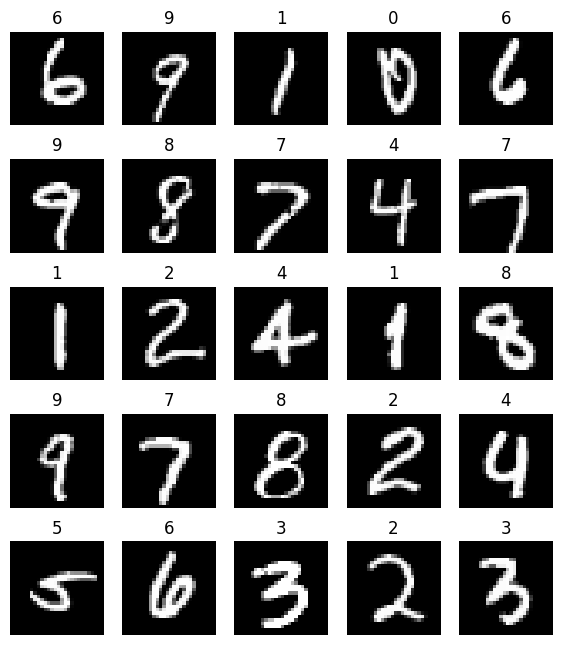

In [46]:
labels_dict = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

fig = plt.figure(figsize=(7, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_index = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_index]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Создание dataloader

Данные при обучении модели редко передаются по одному образцу или все разом, обычно образцы объединяются в пакеты (batches) и уже они передаются на вход модели.

Размер пакета (batch size) часто выбирается как $2^n$ (16, 32, 64, 128) и часто это зависит от доступной памяти.

Загрузчики данных будут использоваться при обучении и тестировании модели и когда все пакеты были перебраны в датасете, это считается одной эпохой обучения. Чтобы между эпохами модель на обучалась на одинаковых пакетах их перемешивают (shuffle).

In [47]:
from torch.utils.data import DataLoader

In [48]:
train_loader = DataLoader(train_set, 32, shuffle=True)
test_loader = DataLoader(test_set, 32, shuffle=False)

**Что означает число 32 в примере для train_loader?**

Ваш ответ: 32 - это размерность пакета (batch_size), т.е. количество образцов данных, которые модель будет обрабатывать одновременно перед выполнением обновлений весов.

**Какая размерность будет у одного пакета данных?**

Ваш ответ: размер одного пакета данных будет (32, 1, 28, 28). Здесь 32 - размер пакета, 1 - количество каналов (черно-белые изображения), 28 - высота, и 28 - ширина изображения.

## Создание модели

Ваша задача при инициализации MLP, создать несколько линейных слоев и функцию активации (например ReLU), которые будут использоваться при прямом проходе в модели. Перед входным слоем не забудьте использовать для изображений `.flatten()`. Чтобы вы могли использовать пакеты данных, вам надо подумать какую часть тензора сделать "плоской".

- Линейный слой `nn.Linear`
- Функция активации `nn.ReLU`

In [49]:
import torch.nn as nn

In [50]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    #
    # Для первого линейного слоя количество входных параметров,
    # должно быть равно количеству значений в изображении.
    # В последнем слое, количество выводов должно быть равно количеству классов
    # в задаче классификации.
    # В промежуточных слоях количество параметров на входе должно совпадать
    # с количеством на выходе у предыдущего слоя.
    # Ваш код
    self.fc1 = nn.Linear(1 * 28 * 28, 120)
    self.fc2 = nn.Linear(120, 80)
    self.fc3 = nn.Linear(80, 10)

  def forward(self, x):
    #
    # Уплощаем данные на входе, передаем их в линейную функцию,
    # после в функцию активации. После последнего линейного слоя,
    # функция активации не требуется.
    #
    # Ваш код
    # x = x.view(-1, 28 * 28)  # можно использовать вместо flatten
    x = x.flatten(start_dim=1)  # изменяет форму тензора так, чтобы он имел размерность (batch_size, 28 * 28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [51]:
model = MLP()

In [52]:
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


In [53]:
for param in model.parameters():
  print(param.shape)

torch.Size([120, 784])
torch.Size([120])
torch.Size([80, 120])
torch.Size([80])
torch.Size([10, 80])
torch.Size([10])


In [54]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

fc1.weight 	 torch.Size([120, 784])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([80, 120])
fc2.bias 	 torch.Size([80])
fc3.weight 	 torch.Size([10, 80])
fc3.bias 	 torch.Size([10])


In [55]:
params_count = (120*784) + 120 + (80*120) + 80 + (10*80) + 10
print("Число параметров в модели:", params_count)

Число параметров в модели: 104690


**Сколько параметров в вашей модели?**

Ваш ответ: 104690

## Функция потерь и оптимизатор

В задаче классификации чаще всего используется функция потерь на основе перекрестной энтропии.

В качестве оптимизатора для параметров модели можно выбрать стохастический градиентный спуск или Adam.

In [56]:
loss_fn = nn.CrossEntropyLoss()

In [57]:
from torch.optim import SGD

LR = 0.0012

optimizer = SGD(model.parameters(), lr=LR)

## Цикл обучения

In [58]:
import torch.nn.functional as F

n_epochs = 20

best_acc = 0

for epoch in range(n_epochs):
  train_loss = 0
  train_correct = 0
  test_loss = 0
  test_correct = 0
  print(f"Эпоха №{epoch+1}")
  model.train() # переключение модели в режим обучения
  for imgs, labels in train_loader:
    #
    # Классический цикл обучения
    optimizer.zero_grad() # 1. Обнуление градиентов с помощью метода zero_grad у оптимизатора
    outputs = model(imgs)  # 2. Получение вывода модели по пакету данных
    # outputs = model(imgs.flatten(start_dim=1))
    loss = loss_fn(outputs, labels)  # 3. Вычисление потерь на основе вывода модели и исходных значений
    loss.backward()  # 4. Вычисление градиентов для параметров
    optimizer.step()  # 5. Обновление параметров с помощью шага ".step()" у оптимизатора
    # 6. Вычисление метрики

    train_loss += loss.item() # прибавьте потери с этой итерации
    # метод .item() - возвращает значение этого тензора
    # в виде стандартного числа Python.

    train_correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item() # Необходимо получить сумму совпавщих значений между исходными индексами классов (labels)
    # и индексами максимальных значений в пакетах данных.
    # Вам пригодятся torch.sum, torch.argmax и .item()

  avg_train_loss = train_loss / len(train_loader) # полученную сумму потерь необходимо разделить на количество пакетов данных len(train_loader)
  train_acc = train_correct / len(train_set) # полученное количество правильно классифицированных изображений
  # необходимо разделить на количество изображений в обучающей выборке
  print(f"Потери на обучающей выборке {avg_train_loss:.5f}")
  print(f"Точность на обучающей выборке: {train_acc*100:.2f}%")

  model.eval() # переключение модели в режим оценивания
  for imgs, labels in test_loader:
    with torch.no_grad(): # работа в контексте отключенного вычисления градиентов
      # Для оценки модели:
      outputs = model(imgs)  # 1. Получение вывода модели по пакету данных
      loss = loss_fn(outputs, labels)  # 2. Вычисление потерь на основе вывода модели и исходных значений
      # 3. Вычисление метрики

      test_loss += loss.item()
      test_correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

  avg_test_loss = test_loss / len(test_loader)
  test_acc = test_correct / len(test_set)
  print(f"Потери на тестовой выборке {avg_test_loss:.5f}")
  print(f"Точность на тестовой выборке: {test_acc*100:.2f}%")

  if test_acc > best_acc:
    best_acc = test_acc
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, "best_model_params.pth")

Эпоха №1
Потери на обучающей выборке 2.27772
Точность на обучающей выборке: 18.06%
Потери на тестовой выборке 2.23783
Точность на тестовой выборке: 38.67%
Эпоха №2
Потери на обучающей выборке 2.14845
Точность на обучающей выборке: 44.52%
Потери на тестовой выборке 2.01187
Точность на тестовой выборке: 48.99%
Эпоха №3
Потери на обучающей выборке 1.76855
Точность на обучающей выборке: 61.17%
Потери на тестовой выборке 1.44729
Точность на тестовой выборке: 70.82%
Эпоха №4
Потери на обучающей выборке 1.17390
Точность на обучающей выборке: 73.59%
Потери на тестовой выборке 0.93437
Точность на тестовой выборке: 77.64%
Эпоха №5
Потери на обучающей выборке 0.82796
Точность на обучающей выборке: 78.79%
Потери на тестовой выборке 0.71262
Точность на тестовой выборке: 81.37%
Эпоха №6
Потери на обучающей выборке 0.66528
Точность на обучающей выборке: 82.45%
Потери на тестовой выборке 0.59413
Точность на тестовой выборке: 84.20%
Эпоха №7
Потери на обучающей выборке 0.56769
Точность на обучающей выб

**Почему для оценки модели стоит отключать вычисление градиентов `with torch.no_grad()`?**

Ваш ответ: вычисление градиентов with torch.no_grad() стоит отключать, потому что для оценки модели не требуется выполнять обратное распространение ошибки и не требуется обновлять веса модели. Отключение вычисления градиентов снижает потребление памяти и вычислительные затраты.

## Загрузка модели и инференс

Ранее были оптимизированы параметры модели и словарь с параметрами для лучшей точности на проверочной выборке был сохранен в виде файла.

Модель обучается для ее использования с реальными данными, что и будет сделано в этой части задания.

Для этого вам потребуется нарисовать цифру в любом графическом редакторе (Paint, Gimp, Photoshop).

Требования к изображению происходят из тех данных, на которых обучалась модель. Поэтому изображение должно быть черно-белое, ширина и высота 28 px, черный фон, белая цифра. Формат может быть как png, так и jpg.

Для загрузки изображения в Google Colab в боковой панели откройте Files (1), и выберите вариант Upload to session storage (2).

Затем файл необходимо считать и подготовить перед тем, как передать в модель.

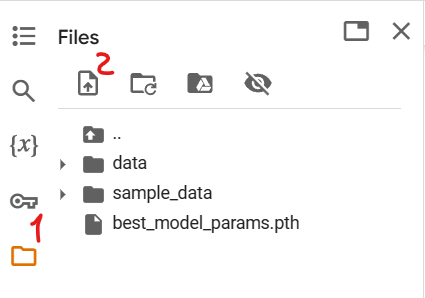

In [64]:
from PIL import Image
img = Image.open('test1.png')
print(f"Ширина и высота {img.size}, количество каналов {len(img.mode)}")
img

Ширина и высота (28, 28), количество каналов 3


**Соответствует ли изображение требованиям?**

Ваш ответ: по размерам изображение соответсвует требованиям, но число каналов 3, вместо 1.

Если количество каналов у вас больше одного, то код далее поможет это исправить.

In [65]:
import torchvision.transforms as transforms
# Раскомментируйте, если у вас цветное изображение
transform_grayscale = transforms.Grayscale()
img = transform_grayscale(img)

# Используем те же преобразования как и при создании датасетов в начале задания
transform_to_tensor = transforms.ToTensor()
x = transform_to_tensor(img)

print('Размерность тензора x:', x.size())

Размерность тензора x: torch.Size([1, 28, 28])


Но работа нашей модели строилась с учетом использования пакетов данных (batches), которые создавали экземпляры класса DataLoader, поэтому для использования одного изображения нам надо имитировать пакет из одного изображения. С этим поможет метод тензора `unsqueeze`, а чтобы не создавать отдельную переменную можно воспользоваться методом `unsqueeze_`.

In [66]:
x.unsqueeze_(0)
print('Размер пакета:', x.size())

Размер пакета: torch.Size([1, 1, 28, 28])


Изображение подготовлено, теперь необходимо воссоздать модель и загрузить в нее параметры, которые дали наилучший результат при обучении.

In [67]:
best_model = MLP()
best_model_params = torch.load("/content/best_model_params.pth")  # Укажите путь до сохраненного файла
state_dict = best_model_params['model_state_dict']  # Из best_model_params извлеките по соответствующему ключу параметры модели
best_model.load_state_dict(state_dict)  # Для best_model используйте метод load_state_dict и передайте в него словарь с параметрами.
best_model.eval()  # Переключите модель в режим проверки (было в цикле обучения)

MLP(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

Осталось воспользоваться моделью. Передайте на вход модели подготовленный тензор. Из вывода модели получите индекс наибольшего значения (`argmax`) и по индексу получите результат из массива ярлыков классов (`test_set.classes`).

In [69]:
with torch.no_grad():
  outputs = best_model(x)  # Получение вывода модели по пакету данных
  predict_idx = torch.argmax(outputs, dim=1)
  predict_value = test_set.classes[predict_idx]
  print("Предсказанное значение:", predict_value)
print("Переданное изображение для предсказания:")
img = Image.open('test1.png')
img

Предсказанное значение: 2 - two
Переданное изображение для предсказания:


**Правильно ли предсказала модель цифру?**

Ваш ответ: да, правильно.

**Лучшая точность на тестовой выборке для вашей модели.**

Ваш ответ: лучшая точность на тестовой выборке: 91.48%

**Что такое пакет данных (batch)?**

Ваш ответ: это набор обучающих примеров, который передается в модель машинного обучения одновременно для вычисления градиентов и обновления параметров в процессе обучения.

**В чем заключается смысл стохастического градиентного спуска?**

Ваш ответ:
Является вариантом классического градиентного спуска, который применяется к стохастическим (случайным) образцам данных.   
Основной смысл SGD заключается в том, чтобы обновлять параметры модели на основе градиента функции потерь, вычисленного по небольшому случайному подмножеству данных (батчу).